# Quaternion Loss Function

In [ ]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.ticker import AutoMinorLocator
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from matplotlib.font_manager import FontProperties


import pandas as pd
from scipy.optimize import minimize
import itertools

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.dataset import random_split
from torch.nn.functional import normalize

from ahrs.filters.madgwick import Madgwick
from ahrs.filters.mahony import Mahony
from ahrs.filters import EKF
from ahrs.common.orientation import acc2q

file_path = '/home/asp/Downloads/AML/final-project/a000_1/data.hdf5'

def plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size, filename=None):
    fig, ax = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle(f'Loss: {loss.item():.4f}, dist_metric: {dist_metric}, agg_type: {agg_type}, normalize: {normal}', fontsize=16)

    legend_elements = [Patch(facecolor='orange', label='Predictions on train data'),
                        Patch(facecolor='red', label='Predictions on test data'),
                        Patch(facecolor='green', label='Orientation from Tango')]

    for i, title in enumerate(['x', 'y', 'z', 'w']):
        ax[i//2, i%2].xaxis.set_minor_locator(AutoMinorLocator())
        ax[i//2, i%2].yaxis.set_minor_locator(AutoMinorLocator())
        if np.linalg.norm(predictions-tango_ori) > np.linalg.norm(predictions+tango_ori):
            predictions = -predictions
        ax[i//2, i%2].plot(time[:train_size], predictions[:train_size, i], color='orange')
        ax[i//2, i%2].plot(time[train_size:], predictions[train_size:, i], color='red')
        ax[i//2, i%2].plot(time, tango_ori[:, i], color='green')
        ax[i//2, i%2].set_title(f'Orientation {title}')
        ax[i//2, i%2].set_ylim([-1, 1])
        ax[i//2, i%2].set_ylabel('Orientation')
        ax[i//2, i%2].set_xlabel('Time')
        ax[i//2, i%2].grid(True, which='both')
        ax[i//2, i%2].grid(which='minor', alpha=0.2, linestyle='--')
        ax[i//2, i%2].grid(which='major', alpha=0.5)
        legend = ax[i//2, i%2].legend(handles=legend_elements, title="Legend", loc='upper left', title_fontsize='medium', fontsize='small')
        legend.get_frame().set_facecolor('lightgrey')
        legend.get_frame().set_edgecolor('black')
    
    plt.tight_layout()

    if filename is not None:
        plt.savefig(f'figures/{filename}.png', dpi = 400)
        plt.savefig(f'figures/{filename}.pdf')
        plt.savefig(f'figures/{filename}.svg')

    plt.show()

In [44]:
if '..' not in sys.path:
    sys.path.append('../')
from utils import load_data
data_dict = load_data(file_path, verbose=True)

N = 20000

if N == 0:
    ekf_ori = data_dict['pose/ekf_ori']
    tango_ori = data_dict['pose/tango_ori']
    gyro = data_dict['synced/gyro']
    gyro_uncalib = data_dict['synced/gyro_uncalib']
    acc = data_dict['synced/acce']
    linacc = data_dict['synced/linacce']
    mag = data_dict['synced/magnet']
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time']
    rv = data_dict['synced/rv']
    game_rv = data_dict['synced/game_rv']
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]

else:
    ekf_ori = data_dict['pose/ekf_ori'][:N]
    tango_ori = data_dict['pose/tango_ori'][:N]
    gyro = data_dict['synced/gyro'][:N]
    gyro_uncalib = data_dict['synced/gyro_uncalib'][:N]
    acc = data_dict['synced/acce'][:N]
    linacc = data_dict['synced/linacce'][:N]
    mag = data_dict['synced/magnet'][:N]
    num_samples = ekf_ori.shape[0]
    time = data_dict['synced/time'][:N]
    rv = data_dict['synced/rv'][:N]
    game_rv = data_dict['synced/game_rv'][:N]
    diffs = np.diff(time)
    dt = np.mean(diffs)
    q_0 = ekf_ori[0,:]

print()

CONTENTS OF HDF5 FILE:
pose
	 ekf_ori
		 
	 tango_ori
		 
	 tango_pos
		 
raw
	 imu
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, wifi_address, wifi_values
	 tango
		 acce, game_rv, gps, gravity, gyro, gyro_uncalib, linacce, magnet, magnetic_rv, pressure, rv, step, tango_adf_pose, tango_pose, wifi_address, wifi_values
synced
	 acce
		 
	 game_rv
		 
	 grav
		 
	 gyro
		 
	 gyro_uncalib
		 
	 linacce
		 
	 magnet
		 
	 rv
		 
	 time
		 



In [45]:
gain = 1.12666016
madgwick_filter = Madgwick(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, gain=gain)
Q_1 = madgwick_filter.Q


k_P = 0.5366640716587453
k_I = 0.4086550384556218
mahony_filter = Mahony(gyr = gyro, acc = acc, mag=mag, dt = dt, q0=q_0, k_P=k_P, k_I=k_I)
Q_2 = mahony_filter.Q


acc_var = 0.3**2
gyro_var = 0.5**2
mag_var = 0.8**2
ekf = EKF(gyr=gyro, acc=acc, mag=mag, dt = dt, q0=q_0, noises= [gyro_var, acc_var, mag_var])
Q_ekf = ekf.Q


if not torch.is_tensor(gyro):
    gyro = torch.from_numpy(gyro).float()
if not torch.is_tensor(acc):
    acc = torch.from_numpy(acc).float()
if not torch.is_tensor(mag):
    mag = torch.from_numpy(mag).float()
if not torch.is_tensor(rv):
    rv = torch.from_numpy(rv).float()
if not torch.is_tensor(game_rv):
    game_rv = torch.from_numpy(game_rv).float()
if not torch.is_tensor(Q_1):
    Q_1 = torch.from_numpy(Q_1).float()
if not torch.is_tensor(Q_2):
    Q_2 = torch.from_numpy(Q_2).float()
if not torch.is_tensor(Q_ekf):
    Q_ekf = torch.from_numpy(Q_ekf).float()
if not torch.is_tensor(tango_ori):
    tango_ori = torch.from_numpy(tango_ori).float()

In [46]:
class LSTMOrientation(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTMOrientation, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(hidden_size * 2, output_size)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        
        out, _ = self.lstm(x, (h0, c0)) 
        out = self.fc(out[:, -1, :])
        
        return out

class CustomLoss(nn.Module):
    def __init__(self, dist_metric='phi2', agg_type='L2', normal=False):
        super().__init__()
        self.dist_metric = dist_metric
        self.agg_type = agg_type
        self.normal = normal

    def forward(self, q1, q2):
        if self.normal:
            q1 = normalize(q1)
            q2 = normalize(q2)
        if self.dist_metric == 'phi2':
            return self.phi2(q1, q2)
        elif self.dist_metric == 'phi4':
            return self.phi4(q1, q2)
        elif self.dist_metric == 'phi5':
            return self.phi5(q1, q2)
        else:
            raise ValueError('Invalid distance metric')

    def phi2(self, q1, q2):
        return self.aggregate(torch.min(torch.norm(q1 - q2), torch.norm(q1 + q2)))

    def phi4(self, q1, q2):
        return self.aggregate(1 - torch.abs(torch.einsum('ij,ij->i', q1, q2)))

    def phi5(self, q1, q2):
        R1 = self.quat_to_rot(q1)
        R2 = self.quat_to_rot(q2)
        return self.aggregate(torch.norm(torch.eye(3, device=q1.device)[None, :, :] - torch.bmm(R1, R2.transpose(-2, -1)), p='fro'))

    def quat_to_rot(self, q):
        q = normalize(q)

        q_r, q_i, q_j, q_k = q.split(1, dim=-1)
        q_r, q_i, q_j, q_k = q_r.squeeze(-1), q_i.squeeze(-1), q_j.squeeze(-1), q_k.squeeze(-1)

        R = torch.zeros((*q.shape[:-1], 3, 3), device=q.device)
        R[..., 0, 0] = 1 - 2 * (q_j ** 2 + q_k ** 2)
        R[..., 0, 1] = 2 * (q_i * q_j - q_k * q_r)
        R[..., 0, 2] = 2 * (q_i * q_k + q_j * q_r)
        R[..., 1, 0] = 2 * (q_i * q_j + q_k * q_r)
        R[..., 1, 1] = 1 - 2 * (q_i ** 2 + q_k ** 2)
        R[..., 1, 2] = 2 * (q_j * q_k - q_i * q_r)
        R[..., 2, 0] = 2 * (q_i * q_k - q_j * q_r)
        R[..., 2, 1] = 2 * (q_j * q_k + q_i * q_r)
        R[..., 2, 2] = 1 - 2 * (q_i ** 2 + q_j ** 2)

        return R


    def aggregate(self, x):
        if self.agg_type == 'L1':
            return torch.mean(torch.abs(x))
        elif self.agg_type == 'L2':
            return torch.mean(x ** 2)
        elif self.agg_type == 'log':
            return -torch.mean(torch.log(x))
        else:
            raise ValueError('Invalid aggregation type')



input_size = 21
hidden_size = 128
num_layers = 3
output_size = 4
num_epochs = 20
learning_rate = 0.01
weight_decay = 0.0035
seq_len = 5
betas = (0.66, 0.96)
amsgrad = True

parameters = {
    'optimizer': 'AdamW',
    'input_size': input_size,
    'hidden_size': hidden_size,
    'num_layers': num_layers,
    'output_size': output_size,
    'num_epochs': num_epochs,
    'learning_rate': learning_rate,
    'weight_decay': weight_decay,
    'seq_len': seq_len,
    'betas': betas,
    'amsgrad': True,
}

Epoch 1/20, Train Loss: 123.4503, Validation Loss: 38.5999
Epoch 2/20, Train Loss: 91.4703, Validation Loss: 84.6087
Epoch 3/20, Train Loss: 177.9135, Validation Loss: 43.8562
Epoch 4/20, Train Loss: 73.3259, Validation Loss: 48.5977
Epoch 5/20, Train Loss: 79.2190, Validation Loss: 46.8254
Epoch 6/20, Train Loss: 68.9791, Validation Loss: 42.4164
Epoch 7/20, Train Loss: 58.7923, Validation Loss: 33.2278
Epoch 8/20, Train Loss: 53.9275, Validation Loss: 25.2474
Epoch 9/20, Train Loss: 52.8663, Validation Loss: 31.3606
Epoch 10/20, Train Loss: 46.3435, Validation Loss: 34.7811
Epoch 11/20, Train Loss: 42.9085, Validation Loss: 26.9654
Epoch 12/20, Train Loss: 40.1557, Validation Loss: 25.3964
Epoch 13/20, Train Loss: 39.2341, Validation Loss: 25.5375
Epoch 14/20, Train Loss: 50.4545, Validation Loss: 32.1234
Epoch 15/20, Train Loss: 43.1902, Validation Loss: 26.0777
Epoch 16/20, Train Loss: 42.4066, Validation Loss: 25.3347
Epoch 17/20, Train Loss: 34.0492, Validation Loss: 33.0697
Epoc

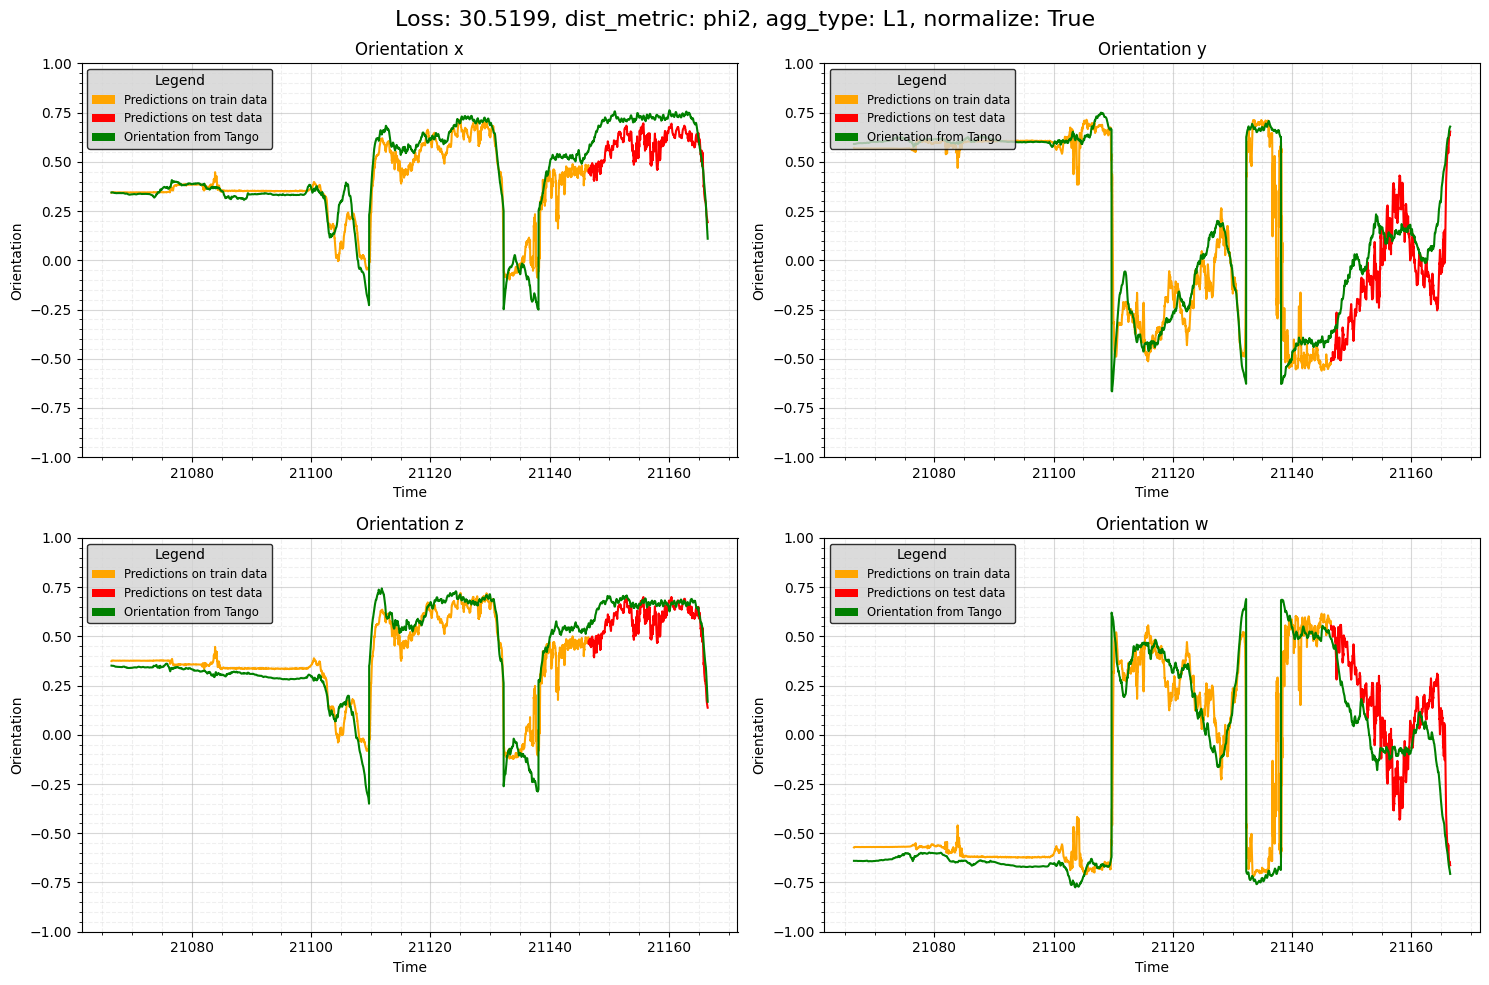

Epoch 1/20, Train Loss: 123.8564, Validation Loss: 34.7001
Epoch 2/20, Train Loss: 93.2918, Validation Loss: 68.9935
Epoch 3/20, Train Loss: 152.9199, Validation Loss: 63.1669
Epoch 4/20, Train Loss: 103.4277, Validation Loss: 50.3967
Epoch 5/20, Train Loss: 84.9133, Validation Loss: 44.1237
Epoch 6/20, Train Loss: 73.8687, Validation Loss: 39.3692
Epoch 7/20, Train Loss: 57.9937, Validation Loss: 34.8212
Epoch 8/20, Train Loss: 55.0802, Validation Loss: 25.3198
Epoch 9/20, Train Loss: 55.4051, Validation Loss: 28.2707
Epoch 10/20, Train Loss: 48.7960, Validation Loss: 33.3247
Epoch 11/20, Train Loss: 43.3201, Validation Loss: 24.8638
Epoch 12/20, Train Loss: 41.1639, Validation Loss: 25.7035
Epoch 13/20, Train Loss: 36.6619, Validation Loss: 26.0621
Epoch 14/20, Train Loss: 36.9276, Validation Loss: 26.7140
Epoch 15/20, Train Loss: 62.8413, Validation Loss: 20.4061
Epoch 16/20, Train Loss: 41.3881, Validation Loss: 33.1828
Epoch 17/20, Train Loss: 44.0665, Validation Loss: 25.7801
Epo

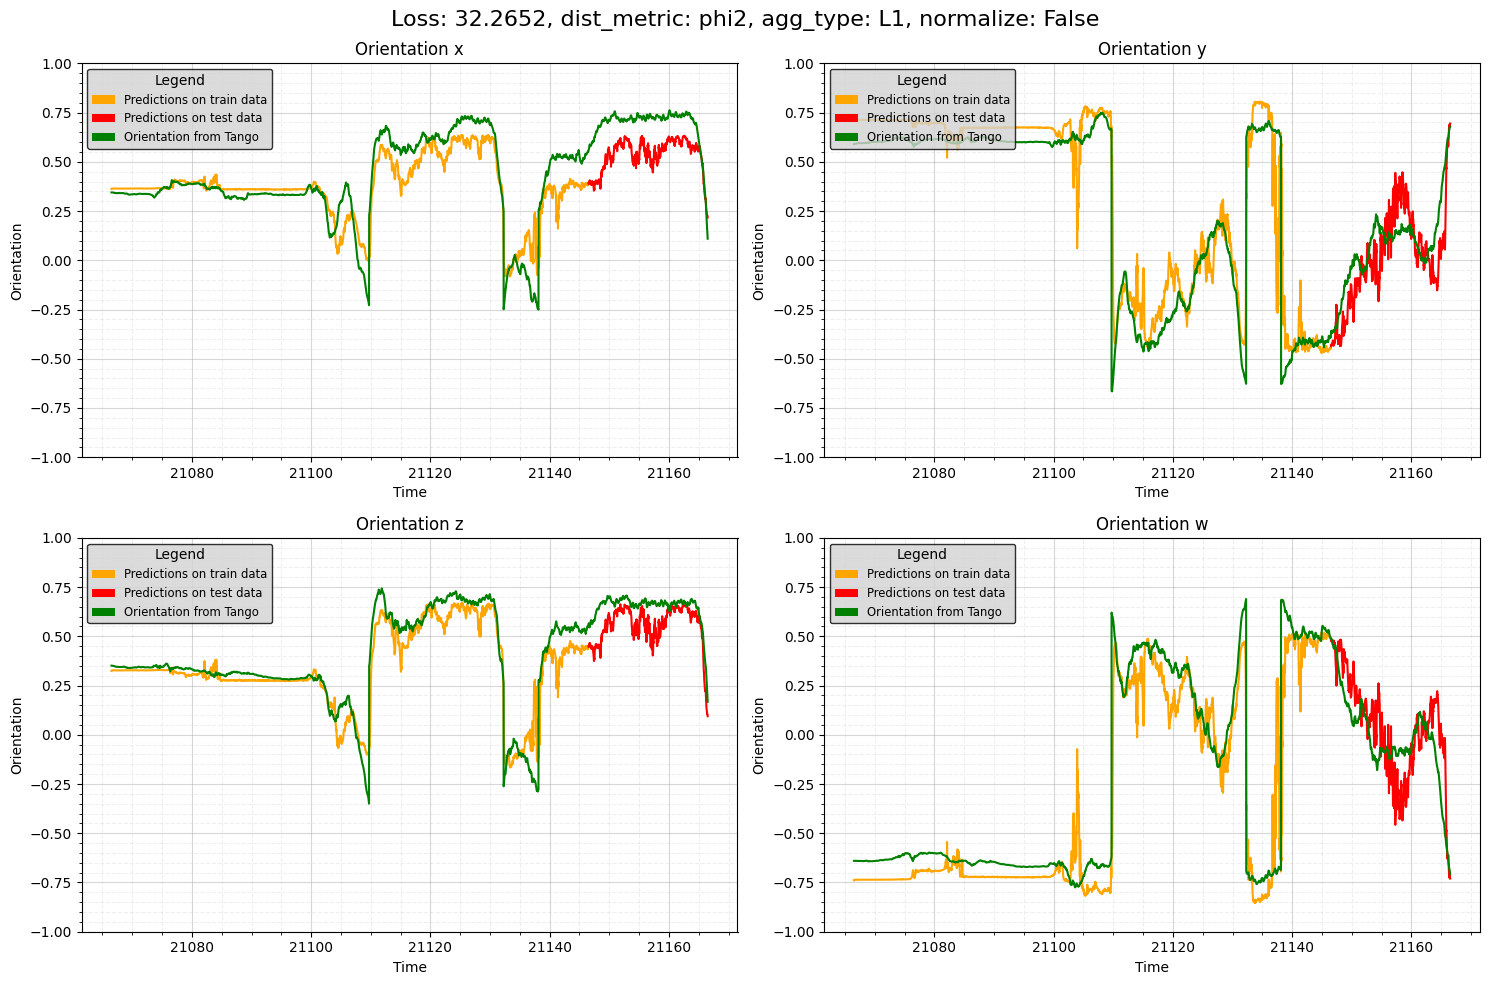

Epoch 1/20, Train Loss: 15866.3535, Validation Loss: 1289.0930
Epoch 2/20, Train Loss: 8690.3887, Validation Loss: 5741.9629
Epoch 3/20, Train Loss: 24008.2949, Validation Loss: 2787.8328
Epoch 4/20, Train Loss: 6119.5049, Validation Loss: 3018.5015
Epoch 5/20, Train Loss: 6291.6045, Validation Loss: 2350.8899
Epoch 6/20, Train Loss: 4673.0605, Validation Loss: 1341.6063
Epoch 7/20, Train Loss: 3192.7607, Validation Loss: 820.8351
Epoch 8/20, Train Loss: 2684.5608, Validation Loss: 618.4746
Epoch 9/20, Train Loss: 2269.3401, Validation Loss: 1026.5116
Epoch 10/20, Train Loss: 2182.4182, Validation Loss: 1179.7000
Epoch 11/20, Train Loss: 2288.7327, Validation Loss: 792.3906
Epoch 12/20, Train Loss: 2009.7643, Validation Loss: 618.9429
Epoch 13/20, Train Loss: 1475.4407, Validation Loss: 678.1581
Epoch 14/20, Train Loss: 1320.2156, Validation Loss: 526.2490
Epoch 15/20, Train Loss: 1139.4218, Validation Loss: 464.7520
Epoch 16/20, Train Loss: 1145.2987, Validation Loss: 395.2882
Epoch 1

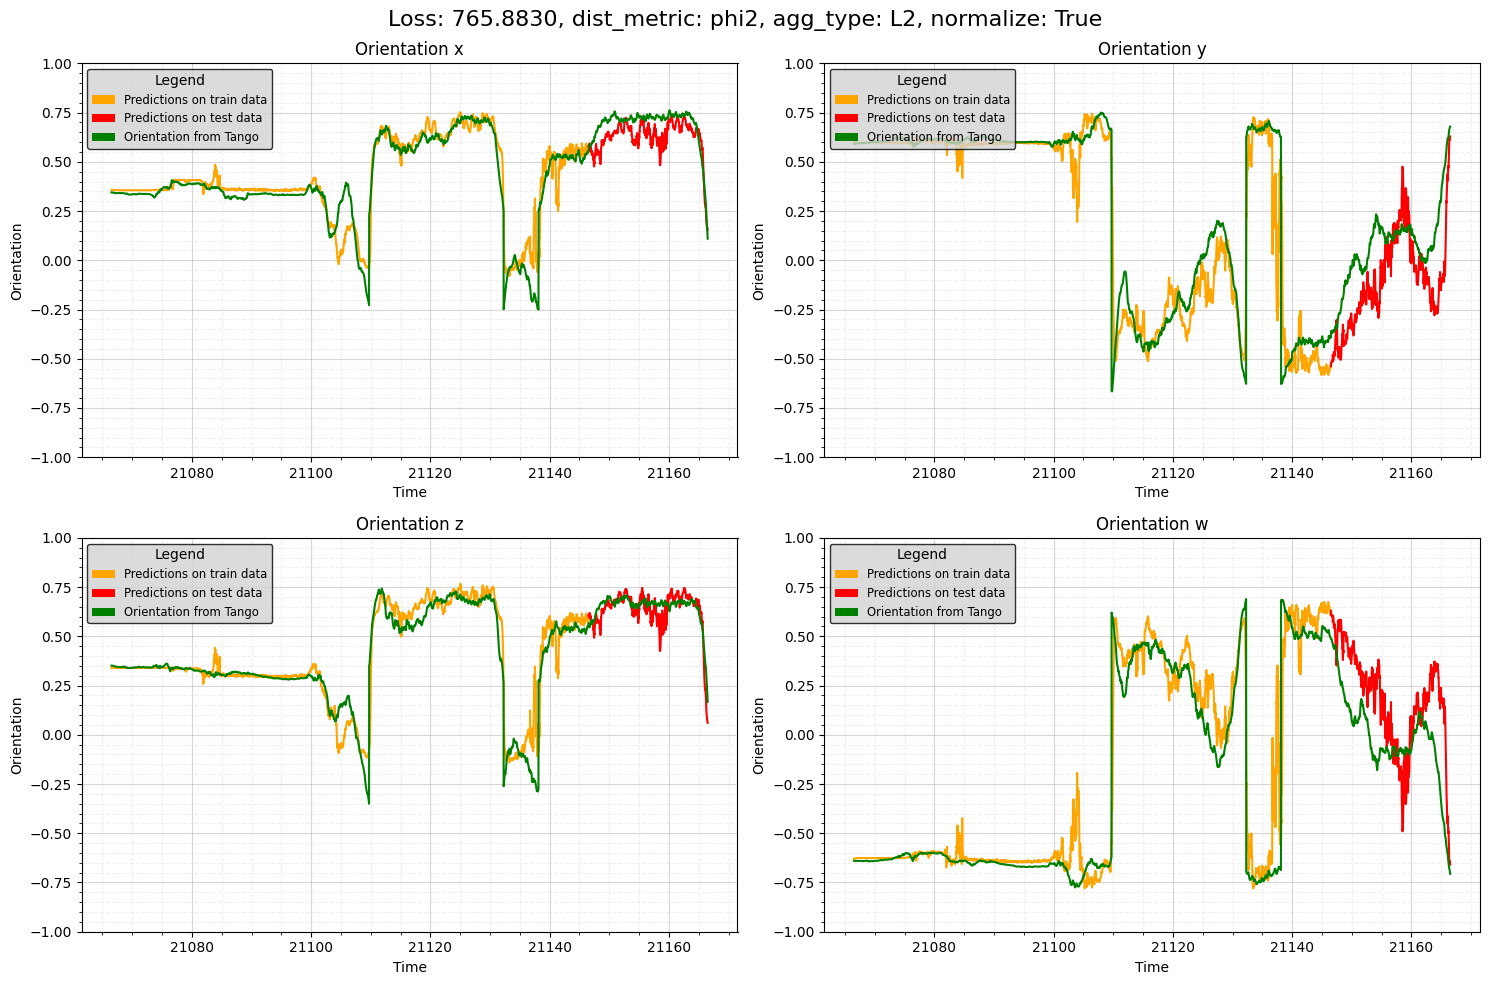

Epoch 1/20, Train Loss: 14590.6758, Validation Loss: 961.7996
Epoch 2/20, Train Loss: 8567.8945, Validation Loss: 2176.7915
Epoch 3/20, Train Loss: 10249.9756, Validation Loss: 3534.3716
Epoch 4/20, Train Loss: 13096.8096, Validation Loss: 2308.2261
Epoch 5/20, Train Loss: 8785.2266, Validation Loss: 1699.2942
Epoch 6/20, Train Loss: 6783.0112, Validation Loss: 1113.6254
Epoch 7/20, Train Loss: 4164.0884, Validation Loss: 1167.3208
Epoch 8/20, Train Loss: 3271.5208, Validation Loss: 1302.5222
Epoch 9/20, Train Loss: 2861.7917, Validation Loss: 946.7359
Epoch 10/20, Train Loss: 2414.2114, Validation Loss: 816.6728
Epoch 11/20, Train Loss: 2119.8335, Validation Loss: 808.9492
Epoch 12/20, Train Loss: 1881.0680, Validation Loss: 730.7311
Epoch 13/20, Train Loss: 1578.4071, Validation Loss: 603.5637
Epoch 14/20, Train Loss: 1446.8998, Validation Loss: 578.5677
Epoch 15/20, Train Loss: 1271.1383, Validation Loss: 395.3168
Epoch 16/20, Train Loss: 1170.1450, Validation Loss: 535.8905
Epoch 1

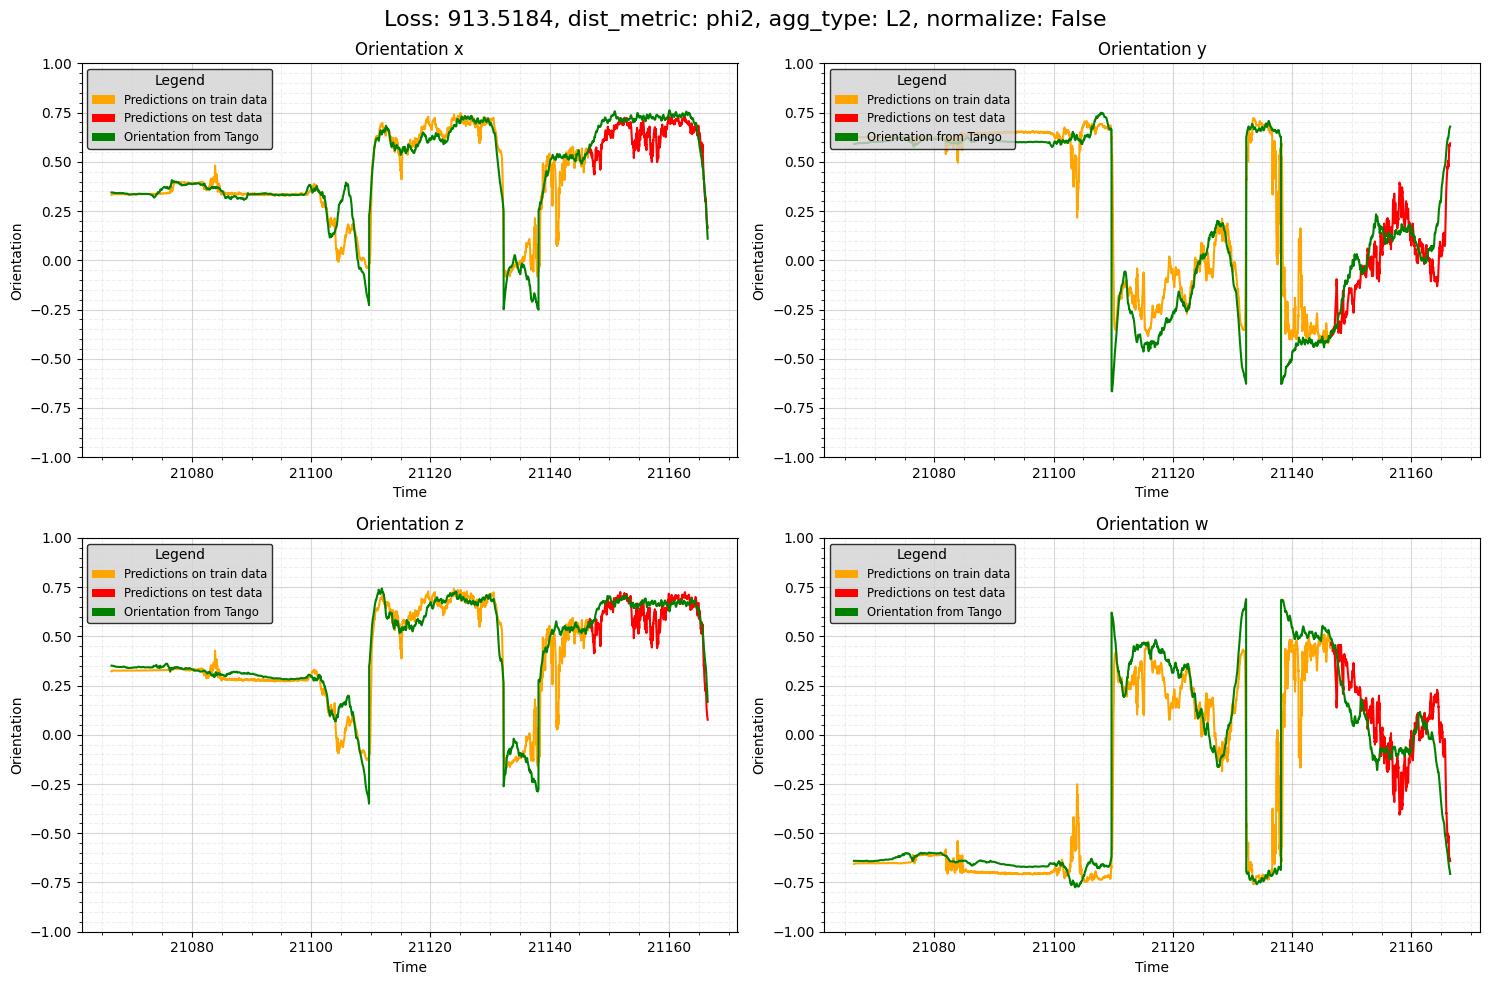

Epoch 1/20, Train Loss: 0.9629, Validation Loss: 0.8401
Epoch 2/20, Train Loss: 0.6546, Validation Loss: 0.4744
Epoch 3/20, Train Loss: 0.8240, Validation Loss: 0.7010
Epoch 4/20, Train Loss: 0.2822, Validation Loss: 0.5215
Epoch 5/20, Train Loss: 0.2230, Validation Loss: 0.5554
Epoch 6/20, Train Loss: 0.2495, Validation Loss: 0.4509
Epoch 7/20, Train Loss: 0.2288, Validation Loss: 0.4932
Epoch 8/20, Train Loss: 0.2063, Validation Loss: 0.6239
Epoch 9/20, Train Loss: 0.2738, Validation Loss: 0.5248
Epoch 10/20, Train Loss: 0.1206, Validation Loss: 0.3962
Epoch 11/20, Train Loss: 0.2823, Validation Loss: 0.3754
Epoch 12/20, Train Loss: 0.0897, Validation Loss: 0.5631
Epoch 13/20, Train Loss: 0.2005, Validation Loss: 0.4689
Epoch 14/20, Train Loss: 0.1470, Validation Loss: 0.3201
Epoch 15/20, Train Loss: 0.1548, Validation Loss: 0.2750
Epoch 16/20, Train Loss: 0.1335, Validation Loss: 0.3394
Epoch 17/20, Train Loss: 0.0678, Validation Loss: 0.4079
Epoch 18/20, Train Loss: 0.0888, Validat

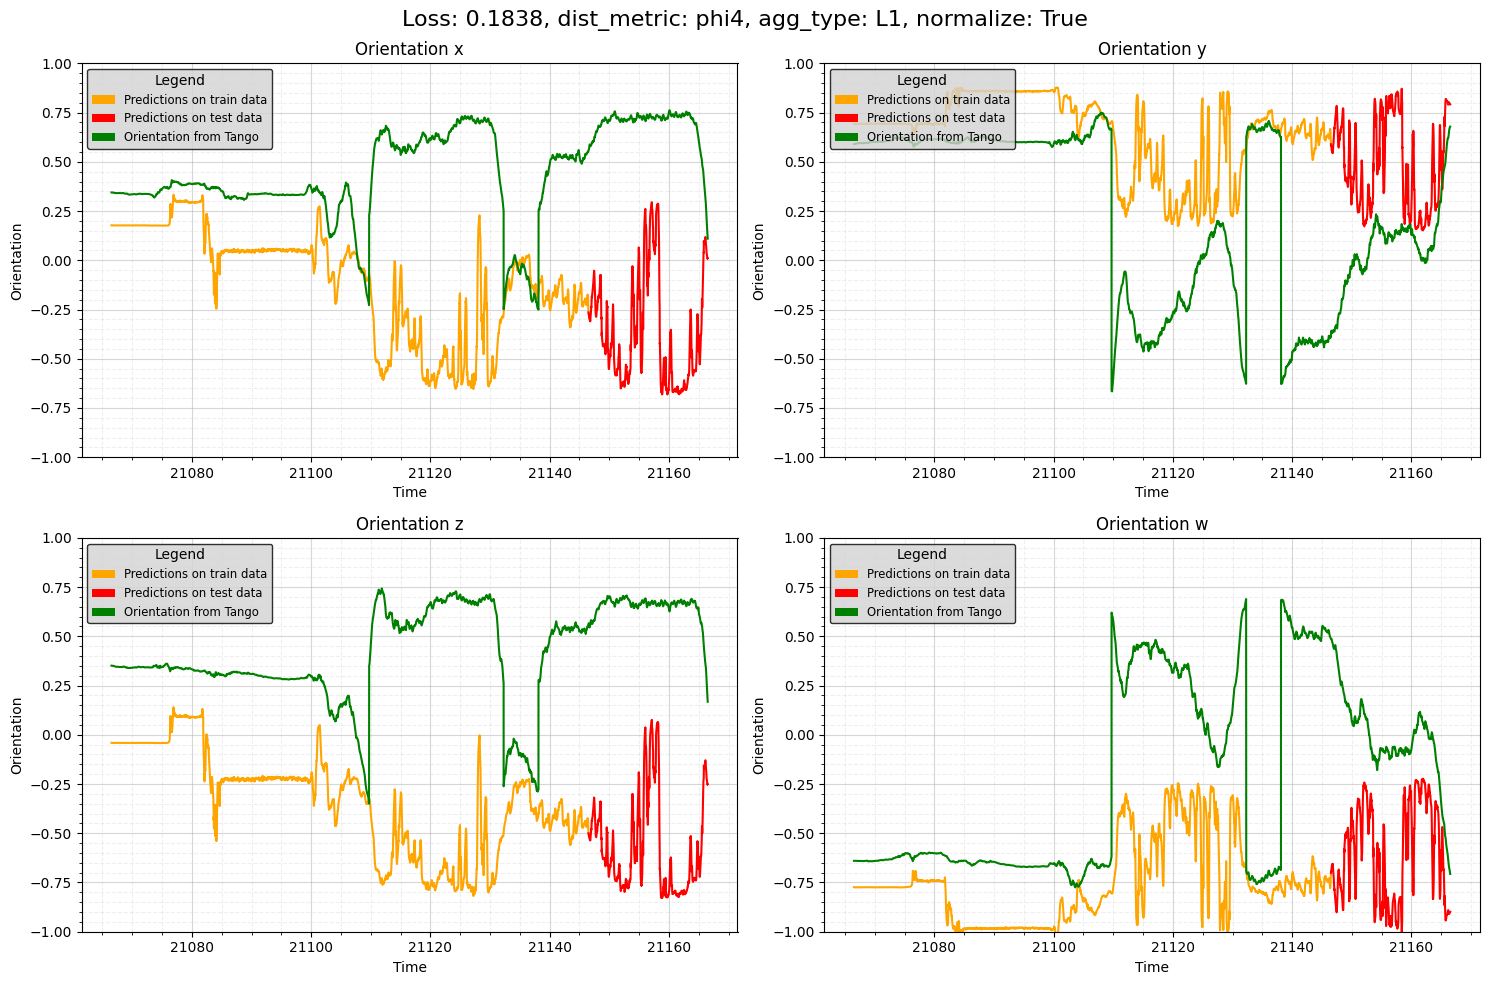

Epoch 1/20, Train Loss: 0.9611, Validation Loss: 0.7848
Epoch 2/20, Train Loss: 0.5789, Validation Loss: 0.6541
Epoch 3/20, Train Loss: 1.2138, Validation Loss: 0.4872
Epoch 4/20, Train Loss: 0.1873, Validation Loss: 0.7982
Epoch 5/20, Train Loss: 0.4174, Validation Loss: 0.6326
Epoch 6/20, Train Loss: 0.3893, Validation Loss: 0.6229
Epoch 7/20, Train Loss: 0.3324, Validation Loss: 0.7014
Epoch 8/20, Train Loss: 0.2956, Validation Loss: 0.7536
Epoch 9/20, Train Loss: 0.2557, Validation Loss: 0.5303
Epoch 10/20, Train Loss: 0.2013, Validation Loss: 0.5072
Epoch 11/20, Train Loss: 0.2141, Validation Loss: 0.4992
Epoch 12/20, Train Loss: 0.1938, Validation Loss: 0.5794
Epoch 13/20, Train Loss: 0.2173, Validation Loss: 0.5231
Epoch 14/20, Train Loss: 0.1182, Validation Loss: 0.4535
Epoch 15/20, Train Loss: 0.1459, Validation Loss: 0.3540
Epoch 16/20, Train Loss: 0.1504, Validation Loss: 0.4053
Epoch 17/20, Train Loss: 0.1582, Validation Loss: 0.3534
Epoch 18/20, Train Loss: 0.1401, Validat

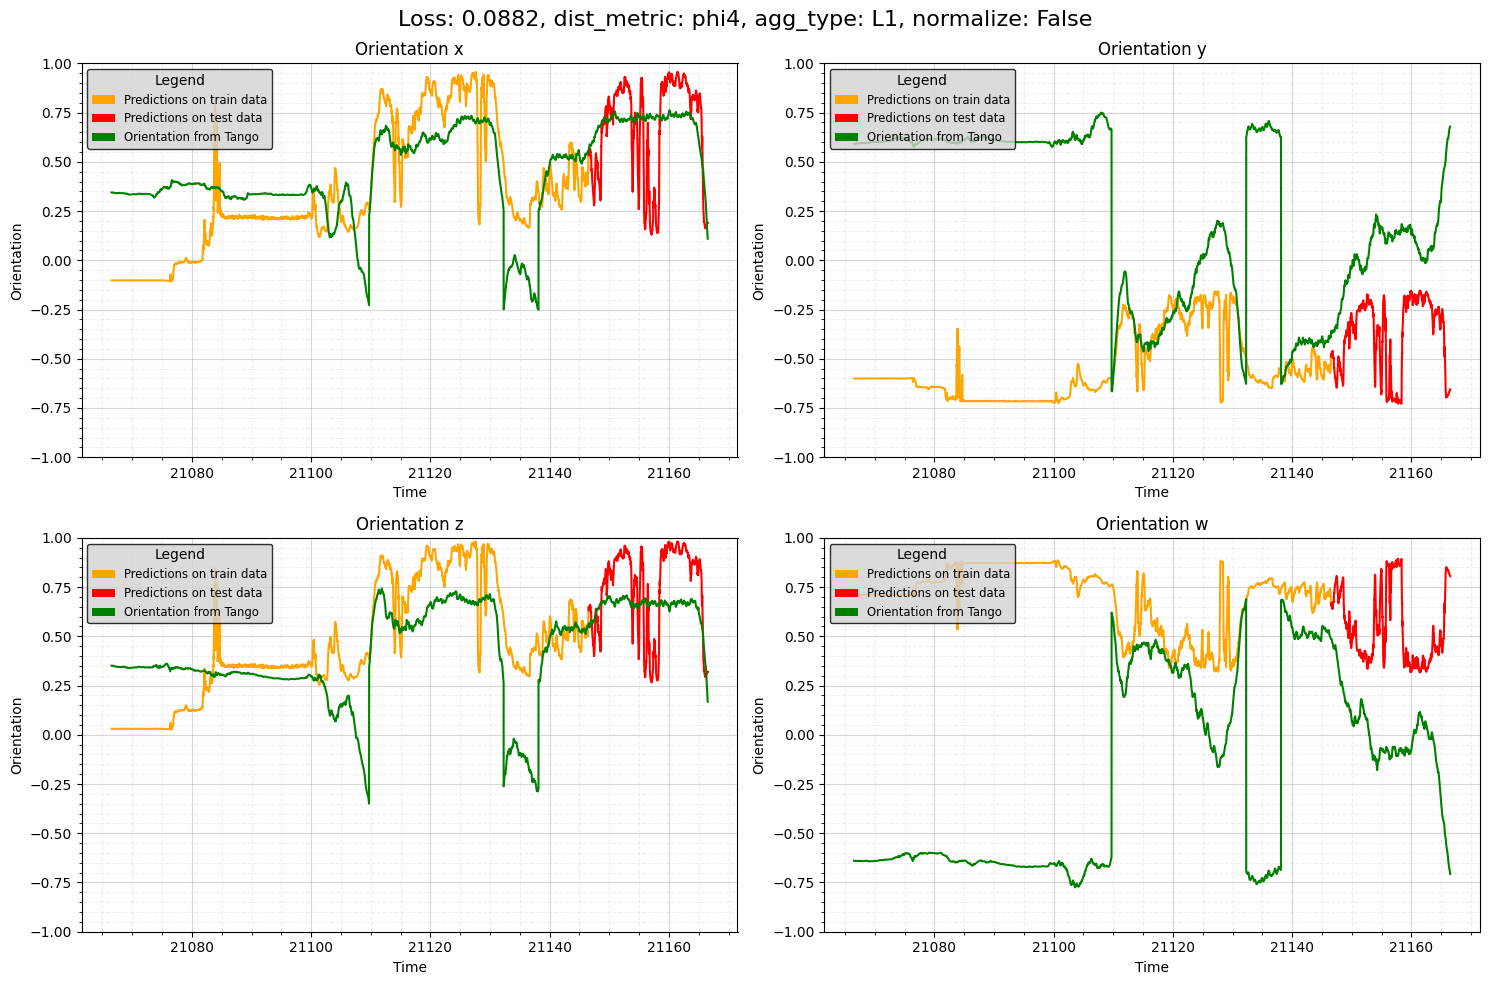

Epoch 1/20, Train Loss: 0.8952, Validation Loss: 0.2100
Epoch 2/20, Train Loss: 0.3688, Validation Loss: 2.7022
Epoch 3/20, Train Loss: 1.6579, Validation Loss: 0.0122
Epoch 4/20, Train Loss: 0.1490, Validation Loss: 0.1395
Epoch 5/20, Train Loss: 0.3328, Validation Loss: 0.1299
Epoch 6/20, Train Loss: 0.2721, Validation Loss: 0.0743
Epoch 7/20, Train Loss: 0.1511, Validation Loss: 0.0404
Epoch 8/20, Train Loss: 0.0827, Validation Loss: 0.0142
Epoch 9/20, Train Loss: 0.0586, Validation Loss: 0.0093
Epoch 10/20, Train Loss: 0.0512, Validation Loss: 0.0068
Epoch 11/20, Train Loss: 0.0357, Validation Loss: 0.0054
Epoch 12/20, Train Loss: 0.0308, Validation Loss: 0.0068
Epoch 13/20, Train Loss: 0.0272, Validation Loss: 0.0164
Epoch 14/20, Train Loss: 0.0219, Validation Loss: 0.0213
Epoch 15/20, Train Loss: 0.0189, Validation Loss: 0.0133
Epoch 16/20, Train Loss: 0.0164, Validation Loss: 0.0072
Epoch 17/20, Train Loss: 0.0139, Validation Loss: 0.0069
Epoch 18/20, Train Loss: 0.0118, Validat

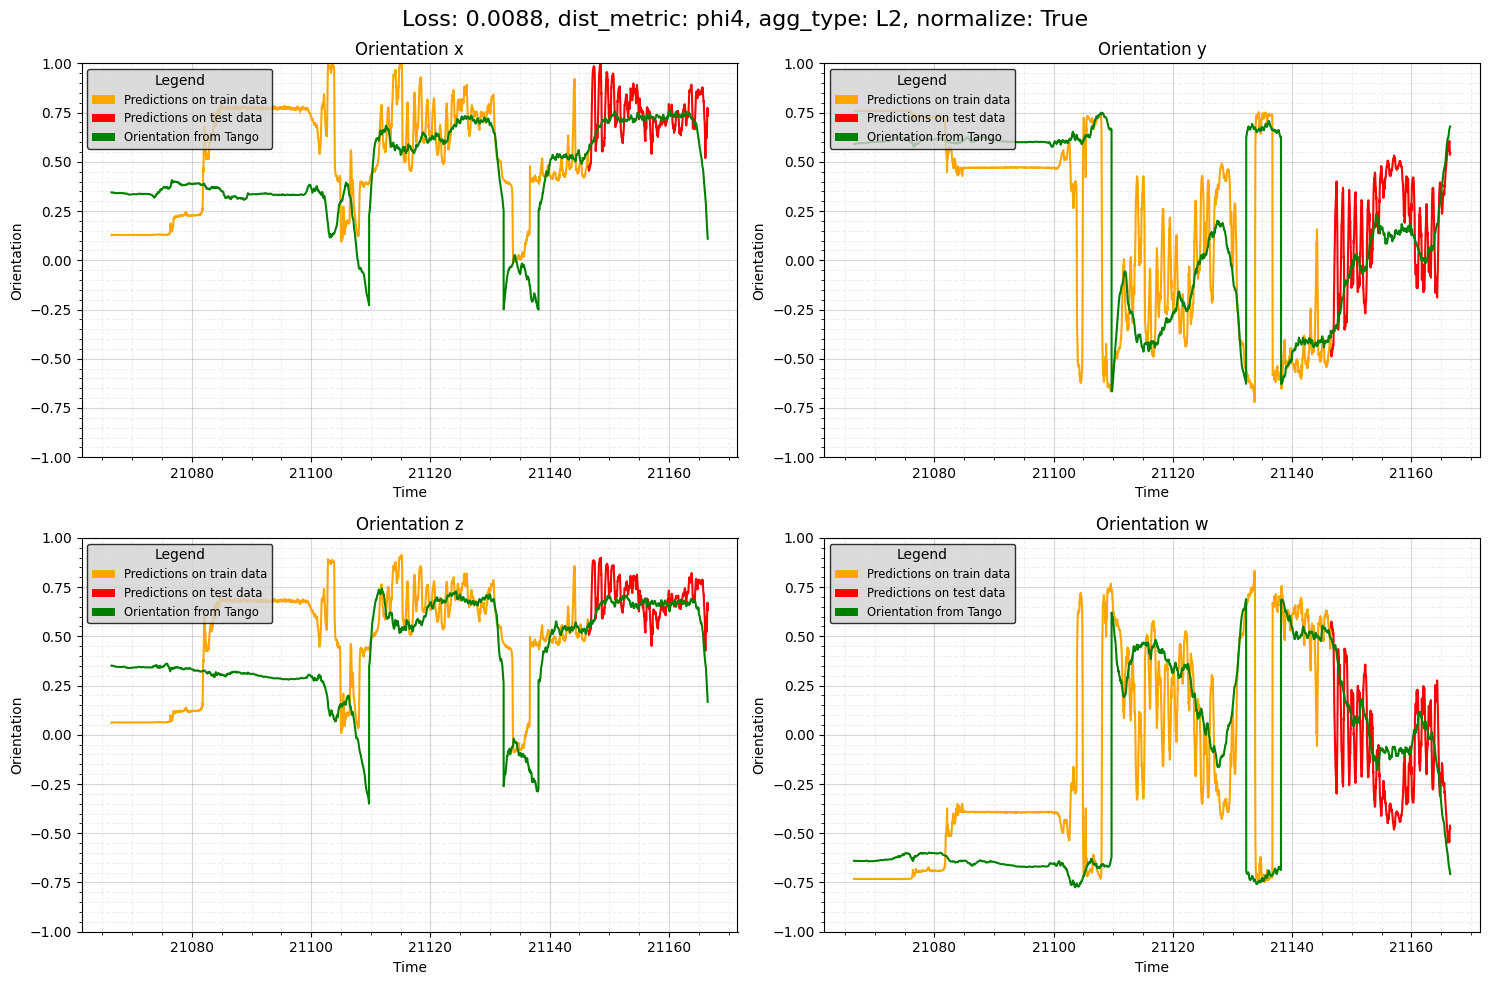

Epoch 1/20, Train Loss: 0.8928, Validation Loss: 0.5799
Epoch 2/20, Train Loss: 0.3458, Validation Loss: 0.3819
Epoch 3/20, Train Loss: 1.7882, Validation Loss: 0.4983
Epoch 4/20, Train Loss: 0.1403, Validation Loss: 0.6004
Epoch 5/20, Train Loss: 0.3475, Validation Loss: 0.5038
Epoch 6/20, Train Loss: 0.2961, Validation Loss: 0.2966
Epoch 7/20, Train Loss: 0.1380, Validation Loss: 0.2112
Epoch 8/20, Train Loss: 0.0917, Validation Loss: 0.1672
Epoch 9/20, Train Loss: 0.0942, Validation Loss: 0.1800
Epoch 10/20, Train Loss: 0.0470, Validation Loss: 0.2203
Epoch 11/20, Train Loss: 0.0439, Validation Loss: 0.2165
Epoch 12/20, Train Loss: 0.0404, Validation Loss: 0.1751
Epoch 13/20, Train Loss: 0.0281, Validation Loss: 0.1424
Epoch 14/20, Train Loss: 0.0208, Validation Loss: 0.1227
Epoch 15/20, Train Loss: 0.0212, Validation Loss: 0.1153
Epoch 16/20, Train Loss: 0.0146, Validation Loss: 0.1232
Epoch 17/20, Train Loss: 0.0132, Validation Loss: 0.1186
Epoch 18/20, Train Loss: 0.0117, Validat

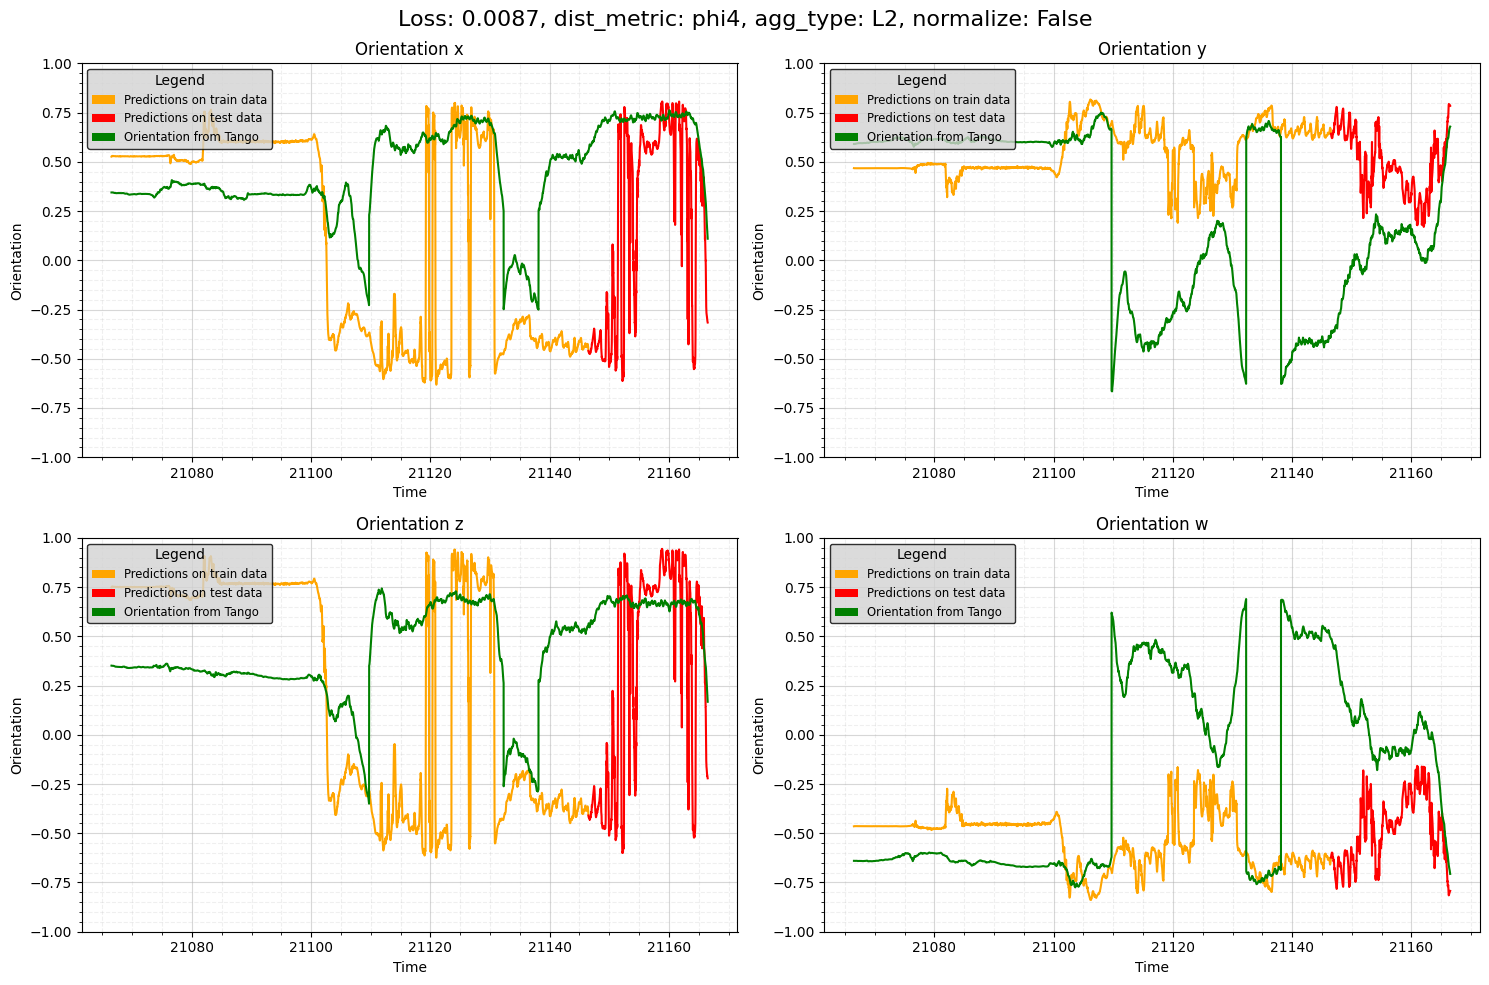

Epoch 1/20, Train Loss: 332.9166, Validation Loss: 108.4022
Epoch 2/20, Train Loss: 257.4167, Validation Loss: 65.4973
Epoch 3/20, Train Loss: 184.2815, Validation Loss: 136.5088
Epoch 4/20, Train Loss: 160.1569, Validation Loss: 111.8536
Epoch 5/20, Train Loss: 131.8982, Validation Loss: 82.0637
Epoch 6/20, Train Loss: 108.6475, Validation Loss: 97.5385
Epoch 7/20, Train Loss: 132.1211, Validation Loss: 97.1399
Epoch 8/20, Train Loss: 141.8079, Validation Loss: 97.2302
Epoch 9/20, Train Loss: 102.1313, Validation Loss: 107.0067
Epoch 10/20, Train Loss: 100.2287, Validation Loss: 101.6315
Epoch 11/20, Train Loss: 95.5123, Validation Loss: 93.3535
Epoch 12/20, Train Loss: 83.6927, Validation Loss: 87.1501
Epoch 13/20, Train Loss: 78.5951, Validation Loss: 80.1522
Epoch 14/20, Train Loss: 79.1728, Validation Loss: 101.0324
Epoch 15/20, Train Loss: 84.6694, Validation Loss: 80.1169
Epoch 16/20, Train Loss: 75.8300, Validation Loss: 83.0471
Epoch 17/20, Train Loss: 60.4393, Validation Loss

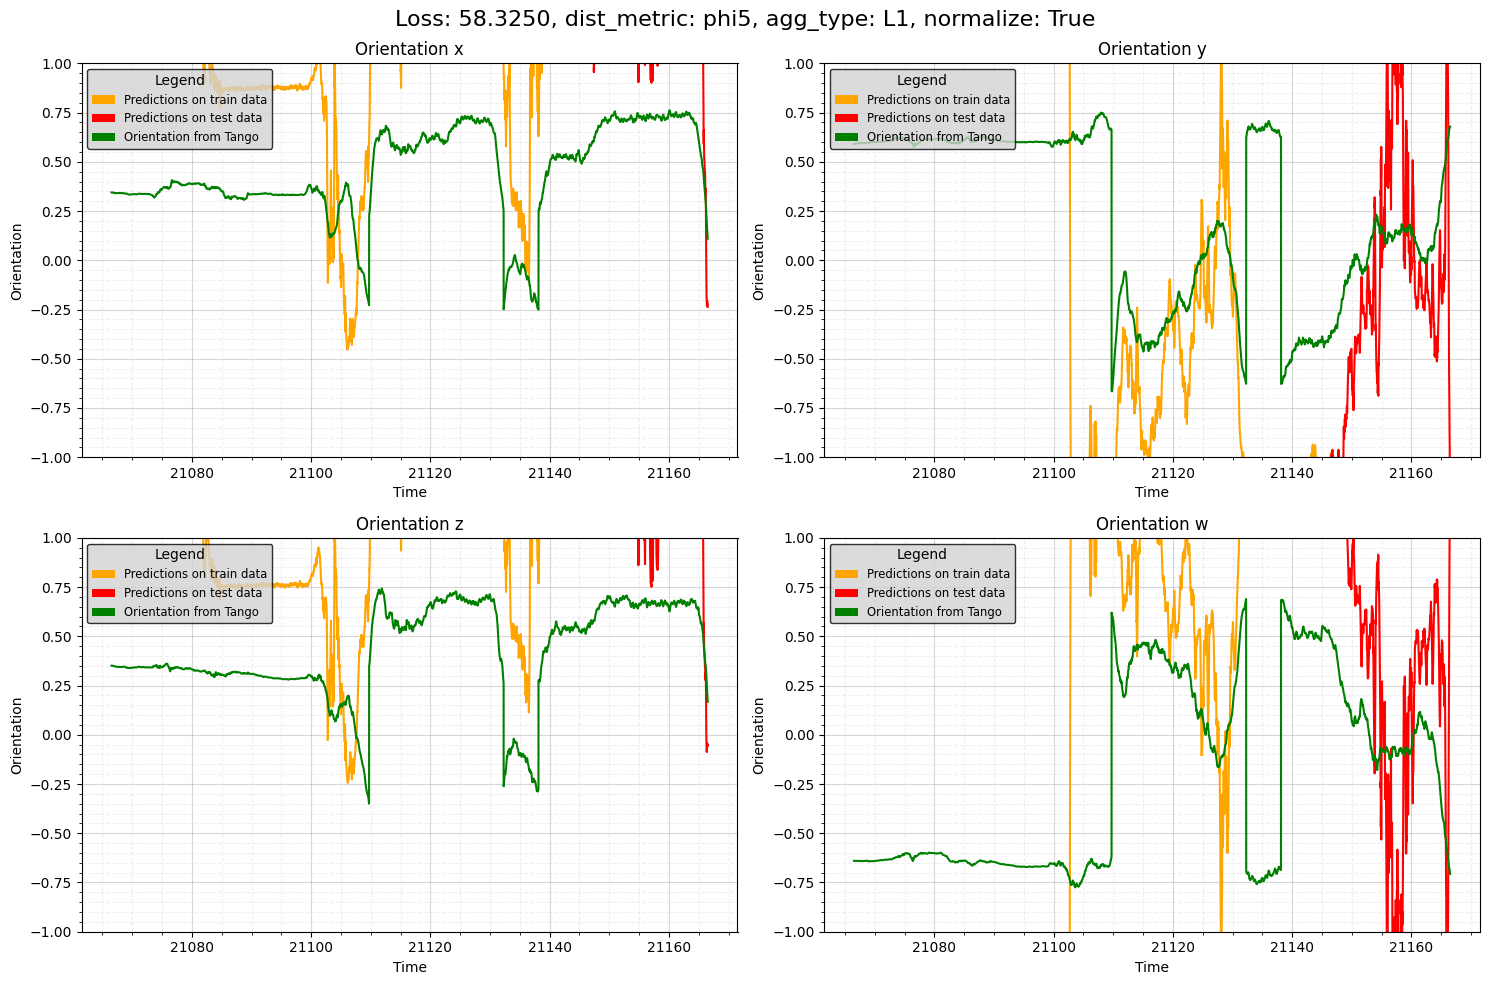

Epoch 1/20, Train Loss: 241.6316, Validation Loss: 169.4393
Epoch 2/20, Train Loss: 307.3654, Validation Loss: 166.7364
Epoch 3/20, Train Loss: 219.7057, Validation Loss: 166.5412
Epoch 4/20, Train Loss: 210.5007, Validation Loss: 157.2811
Epoch 5/20, Train Loss: 160.9346, Validation Loss: 118.9931
Epoch 6/20, Train Loss: 121.1815, Validation Loss: 81.0345
Epoch 7/20, Train Loss: 100.3094, Validation Loss: 115.3339
Epoch 8/20, Train Loss: 125.0594, Validation Loss: 102.2458
Epoch 9/20, Train Loss: 119.7765, Validation Loss: 110.3791
Epoch 10/20, Train Loss: 111.0300, Validation Loss: 112.2815
Epoch 11/20, Train Loss: 107.4527, Validation Loss: 105.8522
Epoch 12/20, Train Loss: 102.2958, Validation Loss: 97.8037
Epoch 13/20, Train Loss: 95.8479, Validation Loss: 91.8153
Epoch 14/20, Train Loss: 86.7018, Validation Loss: 84.0625
Epoch 15/20, Train Loss: 78.7528, Validation Loss: 86.7987
Epoch 16/20, Train Loss: 75.0405, Validation Loss: 75.2999
Epoch 17/20, Train Loss: 73.3513, Validatio

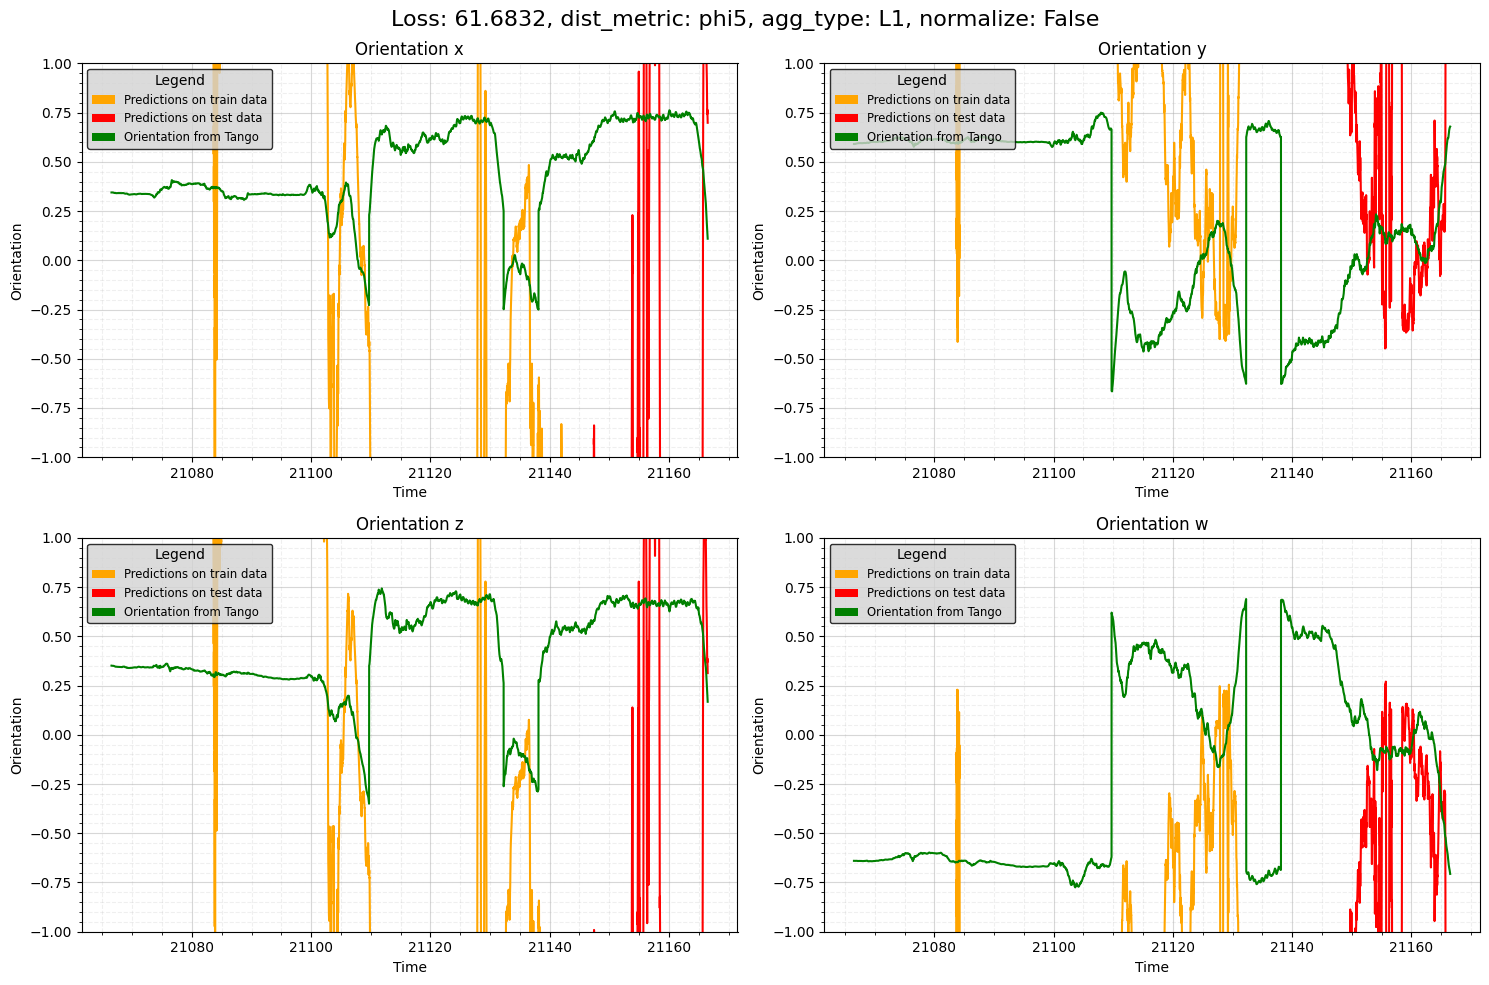

Epoch 1/20, Train Loss: 82791.7344, Validation Loss: 28618.4629
Epoch 2/20, Train Loss: 61017.4219, Validation Loss: 25141.4082
Epoch 3/20, Train Loss: 24292.2168, Validation Loss: 15278.2461
Epoch 4/20, Train Loss: 18155.2559, Validation Loss: 13148.0977
Epoch 5/20, Train Loss: 11417.6592, Validation Loss: 10242.7432
Epoch 6/20, Train Loss: 9391.3525, Validation Loss: 6114.4912
Epoch 7/20, Train Loss: 27878.1855, Validation Loss: 13958.5049
Epoch 8/20, Train Loss: 10668.8086, Validation Loss: 15114.5947
Epoch 9/20, Train Loss: 12824.9609, Validation Loss: 13097.0088
Epoch 10/20, Train Loss: 12253.7617, Validation Loss: 12302.3545
Epoch 11/20, Train Loss: 10697.2520, Validation Loss: 11914.3105
Epoch 12/20, Train Loss: 9580.3477, Validation Loss: 11304.9551
Epoch 13/20, Train Loss: 8429.3613, Validation Loss: 10032.6211
Epoch 14/20, Train Loss: 7714.8223, Validation Loss: 9140.5195
Epoch 15/20, Train Loss: 6490.3213, Validation Loss: 8553.6084
Epoch 16/20, Train Loss: 5997.9229, Valida

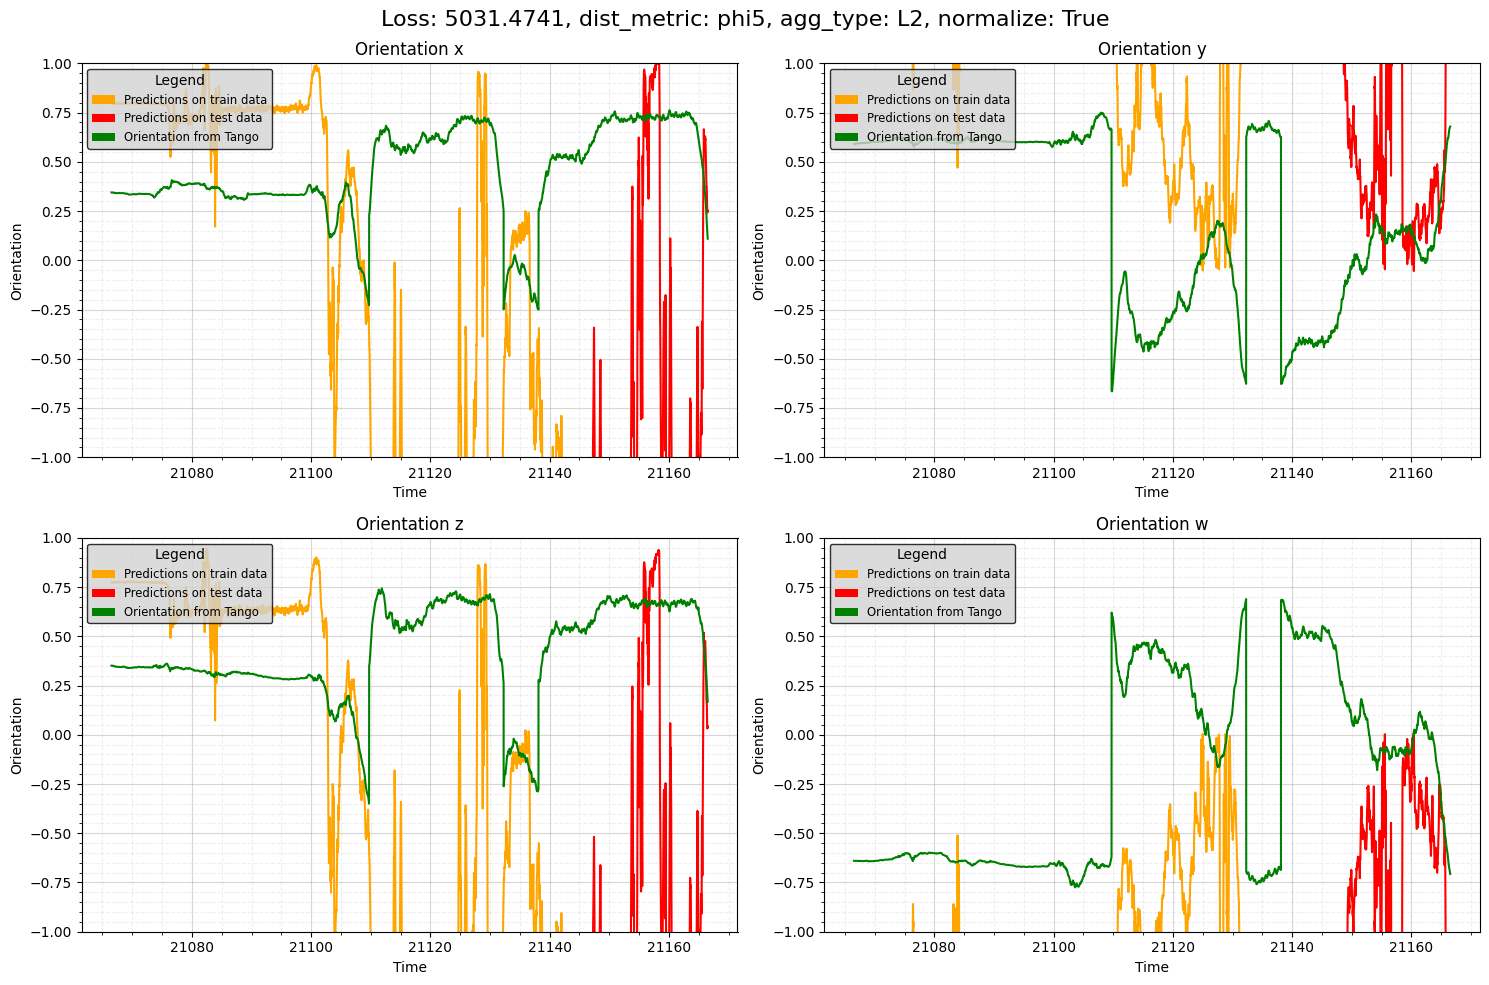

Epoch 1/20, Train Loss: 97194.5312, Validation Loss: 9516.4521
Epoch 2/20, Train Loss: 59776.6094, Validation Loss: 9331.1475
Epoch 3/20, Train Loss: 32122.1875, Validation Loss: 14725.8867
Epoch 4/20, Train Loss: 17044.9492, Validation Loss: 12052.0557
Epoch 5/20, Train Loss: 12426.7705, Validation Loss: 9145.7490
Epoch 6/20, Train Loss: 10759.3711, Validation Loss: 9270.9043
Epoch 7/20, Train Loss: 10453.0293, Validation Loss: 8534.9150
Epoch 8/20, Train Loss: 9087.3711, Validation Loss: 7611.6665
Epoch 9/20, Train Loss: 9129.1572, Validation Loss: 6899.4712
Epoch 10/20, Train Loss: 6817.1763, Validation Loss: 7270.5718
Epoch 11/20, Train Loss: 5966.7515, Validation Loss: 6788.7168
Epoch 12/20, Train Loss: 5570.1377, Validation Loss: 4956.4331
Epoch 13/20, Train Loss: 5170.5527, Validation Loss: 5146.2026
Epoch 14/20, Train Loss: 4825.2129, Validation Loss: 5115.4331
Epoch 15/20, Train Loss: 3779.7439, Validation Loss: 4244.9033
Epoch 16/20, Train Loss: 5101.3262, Validation Loss: 36

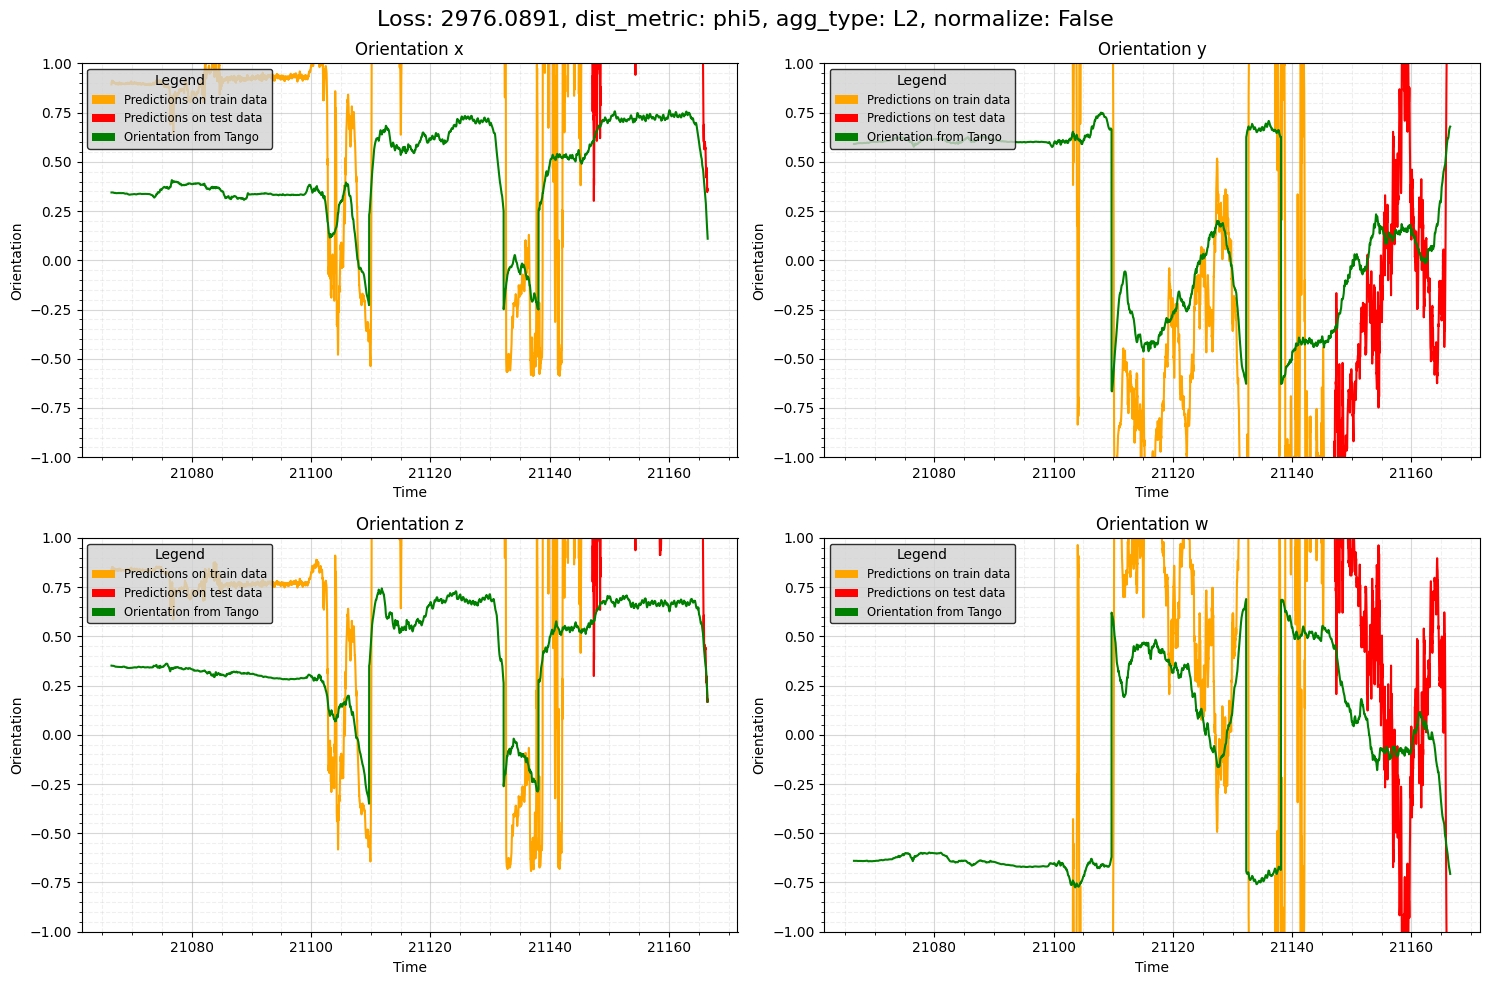

Epoch 1/20, Train Loss: nan, Validation Loss: nan
Epoch 2/20, Train Loss: nan, Validation Loss: nan
Epoch 3/20, Train Loss: nan, Validation Loss: nan
Epoch 4/20, Train Loss: nan, Validation Loss: nan
Epoch 5/20, Train Loss: nan, Validation Loss: nan
Epoch 6/20, Train Loss: nan, Validation Loss: nan
Epoch 7/20, Train Loss: nan, Validation Loss: nan
Epoch 8/20, Train Loss: nan, Validation Loss: nan
Epoch 9/20, Train Loss: nan, Validation Loss: nan
Epoch 10/20, Train Loss: nan, Validation Loss: nan
Epoch 11/20, Train Loss: nan, Validation Loss: nan
Epoch 12/20, Train Loss: nan, Validation Loss: nan
Epoch 13/20, Train Loss: nan, Validation Loss: nan
Epoch 14/20, Train Loss: nan, Validation Loss: nan
Epoch 15/20, Train Loss: nan, Validation Loss: nan
Epoch 16/20, Train Loss: nan, Validation Loss: nan
Epoch 17/20, Train Loss: nan, Validation Loss: nan
Epoch 18/20, Train Loss: nan, Validation Loss: nan
Epoch 19/20, Train Loss: nan, Validation Loss: nan
Epoch 20/20, Train Loss: nan, Validation

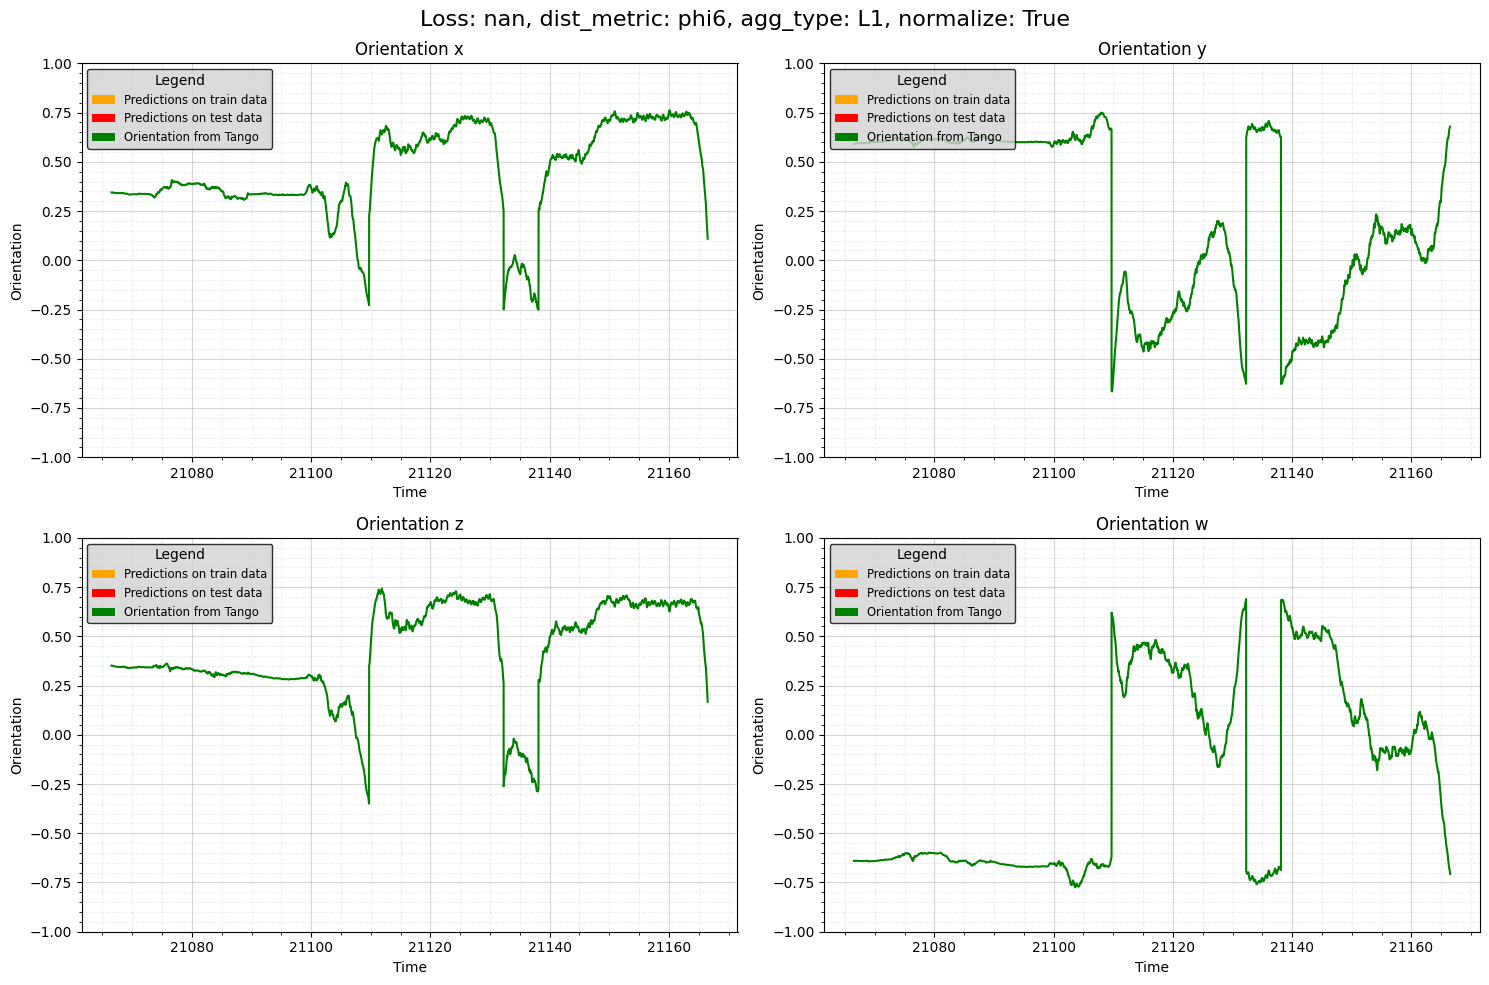

Epoch 1/20, Train Loss: nan, Validation Loss: nan
Epoch 2/20, Train Loss: nan, Validation Loss: nan
Epoch 3/20, Train Loss: nan, Validation Loss: nan
Epoch 4/20, Train Loss: nan, Validation Loss: nan
Epoch 5/20, Train Loss: nan, Validation Loss: nan
Epoch 6/20, Train Loss: nan, Validation Loss: nan
Epoch 7/20, Train Loss: nan, Validation Loss: nan
Epoch 8/20, Train Loss: nan, Validation Loss: nan
Epoch 9/20, Train Loss: nan, Validation Loss: nan
Epoch 10/20, Train Loss: nan, Validation Loss: nan
Epoch 11/20, Train Loss: nan, Validation Loss: nan
Epoch 12/20, Train Loss: nan, Validation Loss: nan
Epoch 13/20, Train Loss: nan, Validation Loss: nan
Epoch 14/20, Train Loss: nan, Validation Loss: nan
Epoch 15/20, Train Loss: nan, Validation Loss: nan
Epoch 16/20, Train Loss: nan, Validation Loss: nan
Epoch 17/20, Train Loss: nan, Validation Loss: nan
Epoch 18/20, Train Loss: nan, Validation Loss: nan
Epoch 19/20, Train Loss: nan, Validation Loss: nan
Epoch 20/20, Train Loss: nan, Validation

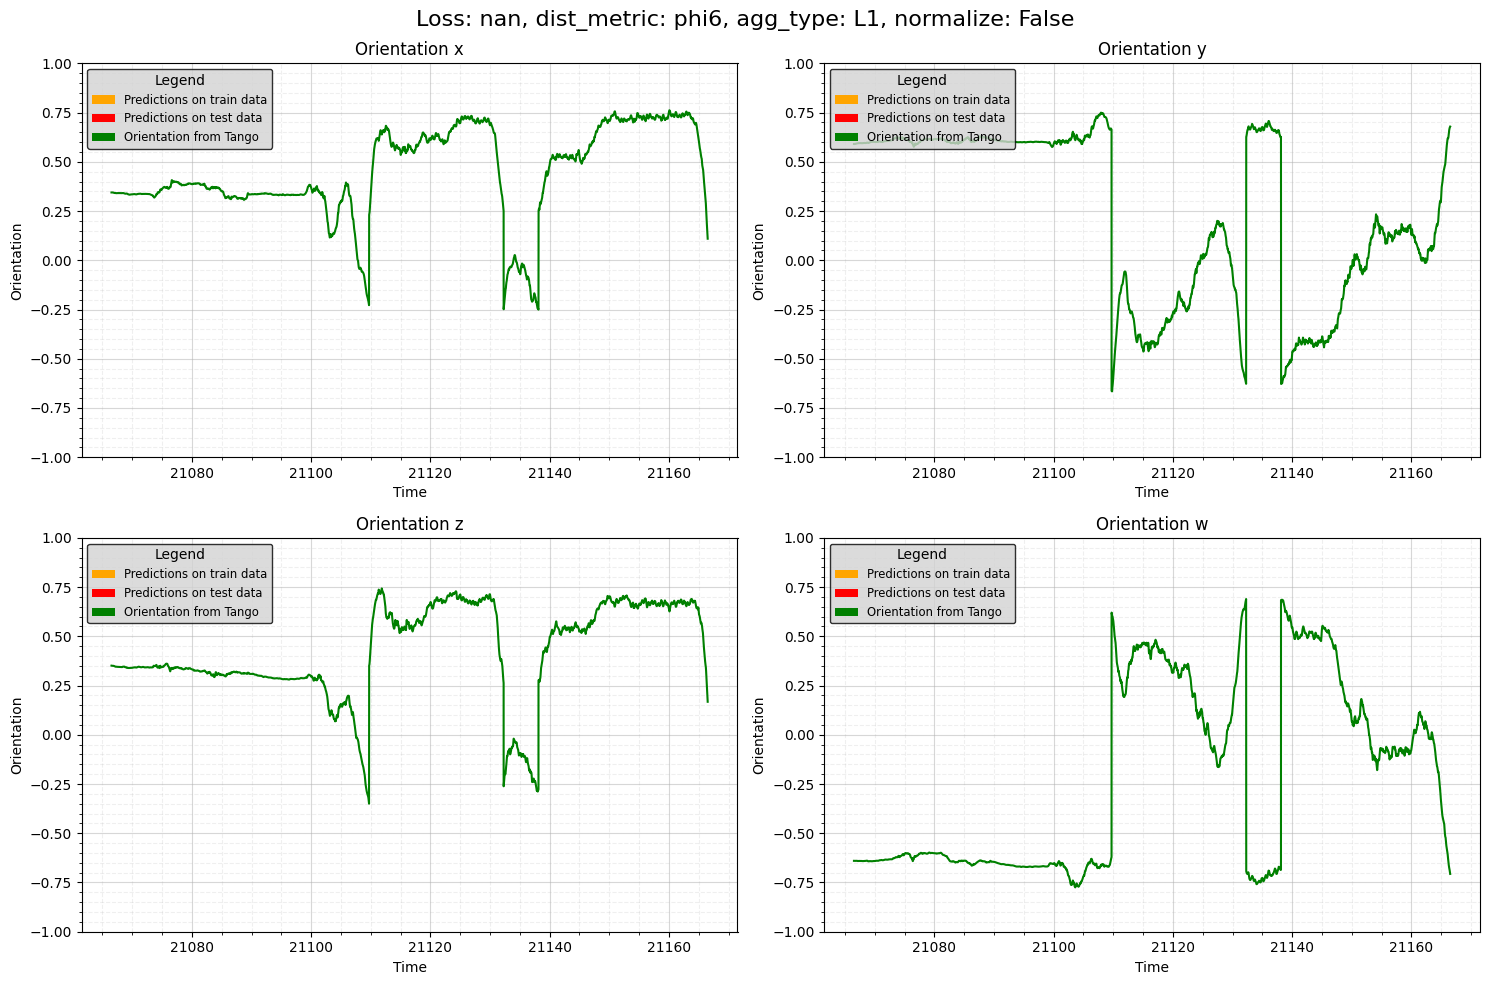

Epoch 1/20, Train Loss: nan, Validation Loss: nan
Epoch 2/20, Train Loss: nan, Validation Loss: nan
Epoch 3/20, Train Loss: nan, Validation Loss: nan
Epoch 4/20, Train Loss: nan, Validation Loss: nan
Epoch 5/20, Train Loss: nan, Validation Loss: nan
Epoch 6/20, Train Loss: nan, Validation Loss: nan
Epoch 7/20, Train Loss: nan, Validation Loss: nan
Epoch 8/20, Train Loss: nan, Validation Loss: nan
Epoch 9/20, Train Loss: nan, Validation Loss: nan
Epoch 10/20, Train Loss: nan, Validation Loss: nan
Epoch 11/20, Train Loss: nan, Validation Loss: nan
Epoch 12/20, Train Loss: nan, Validation Loss: nan
Epoch 13/20, Train Loss: nan, Validation Loss: nan
Epoch 14/20, Train Loss: nan, Validation Loss: nan
Epoch 15/20, Train Loss: nan, Validation Loss: nan
Epoch 16/20, Train Loss: nan, Validation Loss: nan
Epoch 17/20, Train Loss: nan, Validation Loss: nan
Epoch 18/20, Train Loss: nan, Validation Loss: nan


KeyboardInterrupt: 

In [47]:
for dist_metric, agg_type, normal in itertools.product(['phi2', 'phi4', 'phi5', 'phi6'], ['L1', 'L2'], [True, False]):

    train_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)

    input_size = train_data.shape[1]

    train_data = train_data.view(num_samples, -1, input_size)
    train_labels = tango_ori

    train_size = int(0.8*len(train_data))
    valid_size = len(train_data) - train_size

    valid_data, valid_labels = train_data[train_size:], train_labels[train_size:]
    train_data, train_labels = train_data[:train_size], train_labels[:train_size]

    train_data = train_data.view(train_size, -1, input_size)
    valid_data = valid_data.view(valid_size, -1, input_size)

    model = LSTMOrientation(input_size, hidden_size, num_layers, output_size)
    model.to('cpu')
    criterion = CustomLoss(dist_metric=dist_metric, agg_type=agg_type)

    optimizer = optim.AdamW(model.parameters(), betas=betas, lr=learning_rate, weight_decay=weight_decay)

    for epoch in range(num_epochs):
        model.train()
        outputs = model(train_data)
        loss = criterion(outputs, train_labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            valid_outputs = model(valid_data)
            valid_loss = criterion(valid_outputs, valid_labels)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

    print("Finished Training")

    full_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)
    full_data = full_data.view(num_samples, -1, input_size)

    model.eval()
    with torch.no_grad():
        predictions = model(full_data.to('cpu'))

    plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size)

In [ ]:
num_epochs = 200

train_data = torch.cat((gyro, acc, mag, Q_1, Q_2, Q_ekf), dim=1)

print(train_data.shape)

input_size = train_data.shape[1]

train_data = train_data.view(num_samples, -1, input_size)
train_labels = tango_ori

train_size = int(0.8*len(train_data))
valid_size = len(train_data) - train_size

valid_data, valid_labels = train_data[train_size:], train_labels[train_size:]
train_data, train_labels = train_data[:train_size], train_labels[:train_size]

train_data = train_data.view(train_size, -1, input_size)
valid_data = valid_data.view(valid_size, -1, input_size)

model = LSTMOrientation(input_size, hidden_size, num_layers, output_size)
model.to('cpu')
criterion = CustomLoss(dist_metric=dist_metric, agg_type=agg_type)

optimizer = optim.AdamW(model.parameters(), betas=betas, lr=learning_rate, weight_decay=weight_decay)

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_outputs = model(valid_data)
        valid_loss = criterion(valid_outputs, valid_labels)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

print("Finished Training")

full_data = torch.cat((gyro, acc, mag, rv, game_rv, Q_1, Q_2, Q_ekf), dim=1)
full_data = full_data.view(num_samples, -1, input_size)

plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size)

## including rv and game_rv

torch.Size([20000, 29])
Epoch 1/200, Train Loss: 1.0342, Validation Loss: 0.3570
Epoch 2/200, Train Loss: 0.5521, Validation Loss: 1.7424
Epoch 3/200, Train Loss: 1.8669, Validation Loss: 0.7108
Epoch 4/200, Train Loss: 0.4676, Validation Loss: 0.8232
Epoch 5/200, Train Loss: 0.4729, Validation Loss: 0.7449
Epoch 6/200, Train Loss: 0.3770, Validation Loss: 0.5815
Epoch 7/200, Train Loss: 0.2632, Validation Loss: 0.3857
Epoch 8/200, Train Loss: 0.1740, Validation Loss: 0.2384
Epoch 9/200, Train Loss: 0.1348, Validation Loss: 0.1929
Epoch 10/200, Train Loss: 0.1226, Validation Loss: 0.2328
Epoch 11/200, Train Loss: 0.0979, Validation Loss: 0.1847
Epoch 12/200, Train Loss: 0.0728, Validation Loss: 0.1771
Epoch 13/200, Train Loss: 0.0765, Validation Loss: 0.1340
Epoch 14/200, Train Loss: 0.1031, Validation Loss: 0.2804
Epoch 15/200, Train Loss: 0.1208, Validation Loss: 0.1219
Epoch 16/200, Train Loss: 0.0797, Validation Loss: 0.1167
Epoch 17/200, Train Loss: 0.0674, Validation Loss: 0.1809

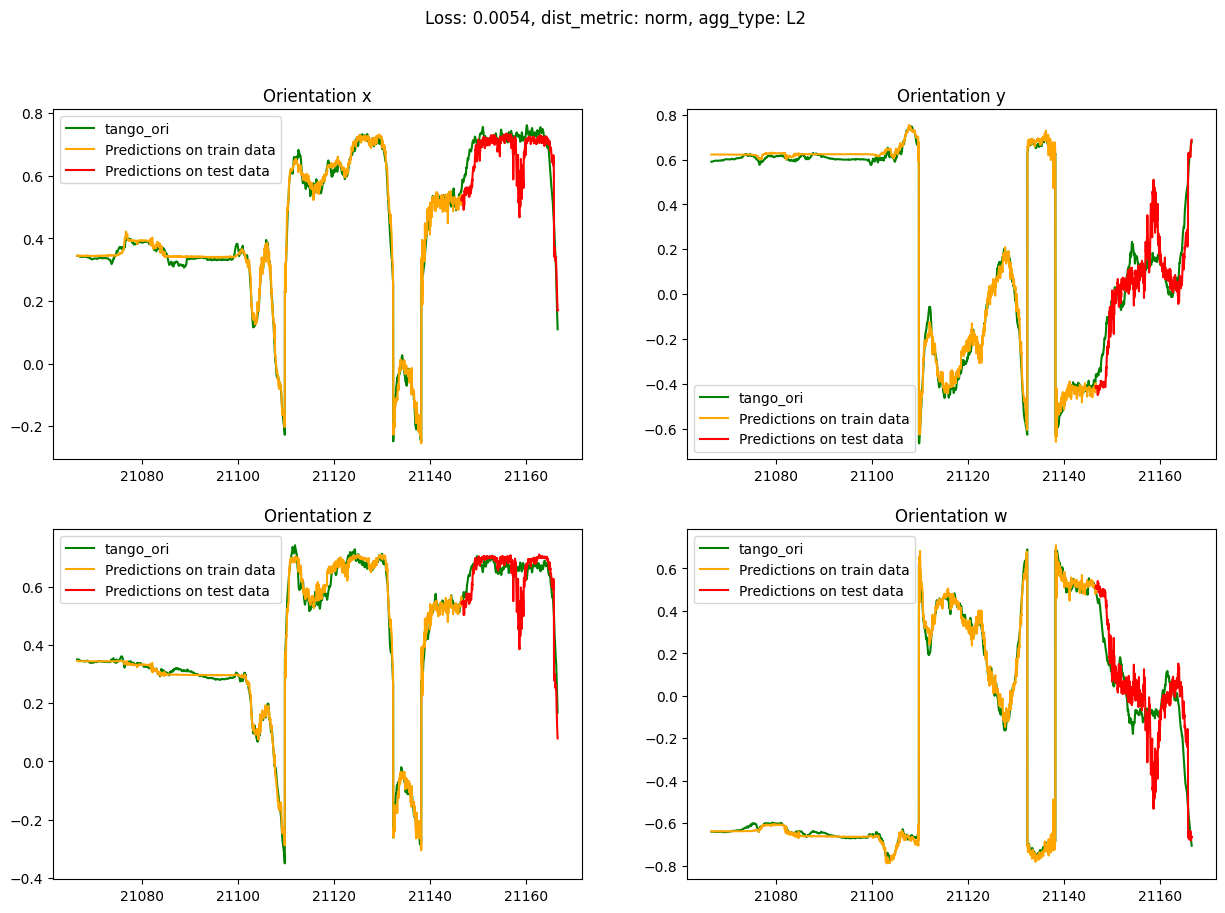

In [ ]:
input_size = 29

train_data = torch.cat((gyro, acc, mag, rv, game_rv, Q_1, Q_2, Q_ekf), dim=1)

print(train_data.shape)

input_size = train_data.shape[1]

train_data = train_data.view(num_samples, -1, input_size)
train_labels = tango_ori

train_size = int(0.8*len(train_data))
valid_size = len(train_data) - train_size

valid_data, valid_labels = train_data[train_size:], train_labels[train_size:]
train_data, train_labels = train_data[:train_size], train_labels[:train_size]

train_data = train_data.view(train_size, -1, input_size)
valid_data = valid_data.view(valid_size, -1, input_size)

model = LSTMOrientation(input_size, hidden_size, num_layers, output_size)
model.to('cpu')
criterion = CustomLoss(dist_metric=dist_metric, agg_type=agg_type)

optimizer = optim.AdamW(model.parameters(), betas=betas, lr=learning_rate, weight_decay=weight_decay)

for epoch in range(num_epochs):
    model.train()
    outputs = model(train_data)
    loss = criterion(outputs, train_labels)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    model.eval()
    with torch.no_grad():
        valid_outputs = model(valid_data)
        valid_loss = criterion(valid_outputs, valid_labels)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {loss.item():.4f}, Validation Loss: {valid_loss.item():.4f}')

print("Finished Training")

full_data = torch.cat((gyro, acc, mag, rv, game_rv, Q_1, Q_2, Q_ekf), dim=1)
full_data = full_data.view(num_samples, -1, input_size)

model.eval()
with torch.no_grad():
    predictions = model(full_data.to('cpu'))

plot_quaternions(loss, dist_metric, agg_type, normal, predictions, tango_ori, time, train_size)